In [1]:
import numpy as np
import scipy.special as sspec
import scipy.stats as ss
import scipy.sparse as sspar
import scipy.linalg as sl
import multiprocessing as mp
import time

%matplotlib inline 
import matplotlib.pyplot as plt

In [2]:
def drift(x):
    out = -x**3 + 4*x
    return out

g = 0.1

In [3]:
alpha = 1.0
def f(x,s,h):
    return np.exp(1j*s*h*drift(x) - h*(np.abs(s)*g)**alpha) 

[0.         1.78281108 3.53383801]
[98.96336707 98.98184828 99.        ]


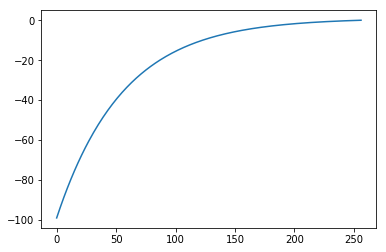

0.018151721718183467


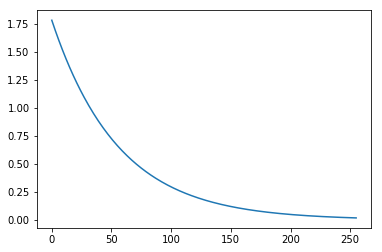

[-99.         -97.21718892 -95.46616199]
[-0.03663293 -0.01815172  0.        ]
257


In [4]:
# set up nonequispaced grids of s and u values
# uvec will have length sres//2+1, which is to implement nonequispaced quadrature later
smax = 100
sres = 512
uvec = smax*(1.0-np.exp(-np.linspace(0,np.log(smax),sres//2 + 1)))
print(uvec[0:3])
print(uvec[(sres//2-2):])
uvec = uvec - np.max(uvec)
plt.plot(uvec)
plt.show()
print(np.min(np.diff(uvec)))
plt.plot(np.diff(uvec))
plt.show()
print(uvec[0:3])
print(uvec[(sres//2-2):])
svec = np.copy(uvec)
ures = len(uvec)
sres = len(svec)
print(sres)

In [15]:
# set the value of h
thish = 0.25

# set the initial condition parameters
mymean = 0
mysd = 0.5

# set the initial pdf
def initp(x):
    return ss.norm.pdf(x,loc=mymean,scale=mysd)

# set the initial charfun
def initpcf(s):
    return np.exp(1j*mymean*s - 0.5*(mysd*s)**2)

In [16]:
# set up x grid for integration
Nx = 1024
L = 8
dx = L/Nx
xvec = np.arange(-L/2,L/2,dx)

In [17]:
# initialize kernel matrix
# kernelmat = np.zeros((sres,sres),dtype='D')

svec[sres-1]

0.0

In [18]:
def computeonerow(i):
    
    outrow = np.zeros(ures,dtype='D')
    s = svec[i]
    
    # handle special Dirac delta case
    if i==(sres-1):
        return sspar.csr_matrix(outrow)
    
    # handle "boundary layer" near Dirac delta
    # if np.abs(svec[i])<1.0:
    #     outrow[sres//2] = 1.0/ds
    #     outrow[(sres//2 + 1)] = s*0.5/(ds*ds)
    #     outrow[(sres//2 - 1)] = -s*0.5/(ds*ds)
    #     return outrow
    
    # compute shifted coordinate
    k = s - uvec
        
    # compute integral for all values of u
    for j in range(Nx):
        
        # compute quadrature points
        x1 = xvec[j]
        x2 = x1 + dx
        
        # product quadrature rule
        m0 = np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), 1j*k, 
                       out=dx*np.ones_like(k,dtype='D'), where=k!=0)
        m1 = np.divide((x2*np.exp(1j*k*x2) - x1*np.exp(1j*k*x1)), 1j*k, 
                       out=0.5*(x2**2 - x1**2)*np.ones_like(k,dtype='D'), where=k!=0)
        m1 += np.divide((np.exp(1j*k*x2) - np.exp(1j*k*x1)), k**2, 
                        out=np.zeros_like(k,dtype='D'), where=k!=0)
        
        # compute quadrature weights
        w1 = -(m1 - x2*m0)/dx
        w2 = (m1 - x1*m0)/dx
        
        # compute integral over [x1, x2]
        outrow += w1*f(x1,s,thish) + w2*f(x2,s,thish)
    
    outrow /= (2.0*np.pi)
    
    # add asymptotic corrections
    # prefac = np.exp(-thish*(np.abs(s)**alpha)*(g**alpha))
    # outrow -= prefac*np.sinc((L/(2.0*np.pi))*k)
    
    outrow[np.abs(outrow)<=1.0e-8] = 0
    
    return sspar.csr_matrix(outrow)


In [19]:
curtime = time.time()
pool = mp.Pool(processes=24)
kernelmat = sspar.vstack(pool.map(computeonerow, range(sres)))
# leftkernelmat, rightkernelmat = map(sspar.vstack, list(zip(*kernelmat)))

# templist = [list(x) for x in zip(*kernelmat)]
# leftkernelmat = sspar.vstack(templist[0])
# rightkernelmat = sspar.vstack(templist[1])

print(kernelmat.shape)
timetaken = time.time() - curtime
print(timetaken)
pool.close()

# bigeig, _ = ssla.eigs(kernelmat,k=1,which='LM')
# print(np.abs(bigeig[0]*ds))
# bigeig, _ = ssla.eigs(kernelmat-kernelmat[sres//2,],k=1,which='LM')
# print(np.abs(bigeig[0]*ds))


(257, 257)
8.251176118850708


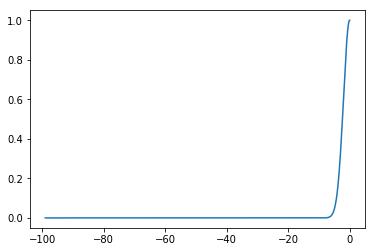

In [20]:
# svec = svec[:-1]
plt.plot(svec, np.abs(initpcf(svec)))

In [21]:
# testmat = np.random.random((3,3))
# print(testmat)

# leave out the first column
# print(testmat[:,1:])

# leave out the last column
# print(testmat[:,:-1])

# cf = initpcf(svec)
# print(len(cf))
# print(sres)
# cf[(sres-1)//2]

du = np.hstack([np.zeros(1), np.diff(uvec)])
cf = initpcf(svec)

print(len(svec))
print(len(du), len(cf))
print(kernelmat.shape)
kernelmatdense = kernelmat.todense()
print(kernelmatdense.shape)
kernelmatsnip = sspar.csr_matrix(kernelmatdense[:,:-1],dtype='D')
print(kernelmatsnip.shape)

257
257 257
(257, 257)
(257, 257)
(257, 256)


1.87561116615
1.0
2.03164904131
1.0
2.01639789677
1.0
1.99300589166
1.0
1.96732808386
1.0
1.93957926176
1.0
1.90775076089
1.0
1.96704474103
1.0
1.97823163196
1.0
1.97802130104
1.0
1.97430515359
1.0
1.98923682099
1.0
1.98329234119
1.0
1.97369921353
1.0
1.95845261156
1.0


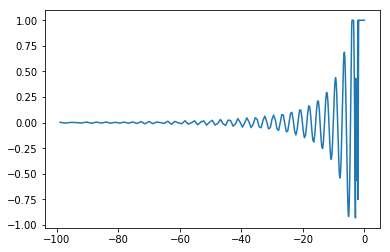

In [22]:
du = np.hstack([np.zeros(1), np.diff(uvec)])
cf = initpcf(svec)
numsteps = 15
for i in range(numsteps):
    newcf = kernelmatsnip.dot(cf[1:]*du[1:])
    prefac = np.exp(-thish*(np.abs(svec)**alpha)*(g**alpha))
    newcf += prefac*cf
    print(np.max(np.abs(newcf)))
    newcf[np.abs(newcf) > 1] /= newcf[np.abs(newcf) > 1]
    print(np.max(np.abs(newcf)))
    cf = newcf

plt.plot(svec,np.real(newcf))

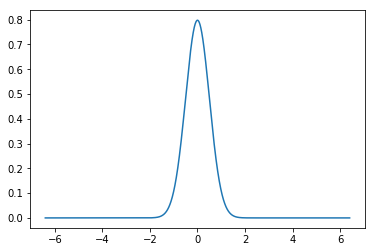

In [161]:
# set up x grid for plotting
Nxplot = 16384
Lplot = 12.8
dxplot = Lplot/Nxplot
xplot = np.arange(-Lplot/2,Lplot/2,dxplot)

# initial PDF
plt.plot(xplot, initp(xplot))

In [ ]:
# Fourier matrix
fouriermat = np.zeros((Nxplot,sres),dtype='D')
for i in range(Nxplot):
    fouriermat[i,] = np.exp(-1j*uvec*xplot[i])/(2.0*np.pi)


In [ ]:
# PDF at next time step
plt.plot(xplot, np.real(dxplot*np.dot(fouriermat,cf)))

In [ ]:
np.save(file='kernelmatNEh0.25s2500',arr=kernelmat)

In [ ]:
plt.plot(du)